# Tutorial: ViT Finetuning and Inference

In [1]:
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torch

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import webdataset as wds
import random
import io
import os

from transformers import ViTImageProcessor, ViTModel
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from torchmetrics.classification import F1Score

In [2]:
# Here, choose the GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

## Load data

I store the data in binary format using `webdataset` and open the batches while training the model to avoid overloading the memory when training with large datasets. However, I will load the data into memory to make it similar to data saved directly as PNGs, arrays, or tensors. Anyway, you can use another way to store and read the data and use a custom `Dataset` and `DataLoader` from PyTorch.

What should matter to you is `train_data` and `val_data`. Once you have the data like the ones in the mentioned variables, you will be able to use the code directly to train the model. The first dimension of the key called pixel_values is the number of objects in the dataset, and the other dimensions correspond to the pixels and channels.

In [3]:
def get_shards_path(base_path, split):
    shards_path = f'{base_path}/{split}/fold_0'
    shard_files = [f for f in os.listdir(shards_path) if f.endswith(".tar.gz")]
    
    if shard_files:
        min_index = min(int(f.split('-')[1].split('.')[0]) for f in shard_files)
        max_index = max(int(f.split('-')[1].split('.')[0]) for f in shard_files)
        dataset_url = f"{shards_path}/imgs_lc-{{{min_index:06d}..{max_index:06d}}}.tar.gz"
        return dataset_url
    else:
        raise FileNotFoundError(f"No shard files found in the directory: {shards_path}")

def fn_decode(sample):
    for key, value in sample.items():
        if key.endswith(".pth"):
            sample[key] = torch.load(io.BytesIO(value), weights_only=True)
        elif key.endswith(".txt"):
            sample[key] = value.decode("utf-8") 
        elif key.endswith(".cls"):
            sample[key] = int(value) 
    return sample

def get_input_model(sample):
    sample = fn_decode(sample)

    sample_mod = sample['pixel_values.pth']
    sample_mod = sample_mod.permute(1, 2, 0, 3)
    sample_mod = sample_mod.reshape(sample_mod.size(0), sample_mod.size(1), -1)
    sample['pixel_values.pth'] = sample_mod

    input_dict = {
        'id': sample['id.txt'],
        'pixel_values': sample['pixel_values.pth'],
        'y_true': sample['label.cls'],
    }
    return input_dict

def load_data_into_memory(base_path, split):
    dataset_url = get_shards_path(base_path, split)
    dataset = wds.WebDataset(dataset_url, shardshuffle=False)
    data_in_memory = []
    for sample in dataset:
        processed_sample = get_input_model(sample)
        data_in_memory.append(processed_sample)

    data_in_memory_dict = {}
    for key in data_in_memory[0].keys():
        data_in_memory_dict[key] = np.stack([d[key] for d in data_in_memory])
    
    return data_in_memory_dict

# Definir la ruta base
base_path = 'data_6bands_noGrid'

# Cargar los datos de train y val
train_data = load_data_into_memory(base_path, 'train')
val_data = load_data_into_memory(base_path, 'val')

In [4]:
train_data.keys()

dict_keys(['id', 'pixel_values', 'y_true'])

In [5]:
train_data['id']

array(['713', '1124', '1227', ..., '130755807', '130762946', '130779836'],
      dtype='<U9')

In [6]:
train_data['id'].shape

(6278,)

In [7]:
train_data['pixel_values'].shape

(6278, 224, 224, 3)

In [8]:
train_data['y_true']

array([ 1,  3,  4, ...,  3,  5, 11])

Show 3 random images from the training set.

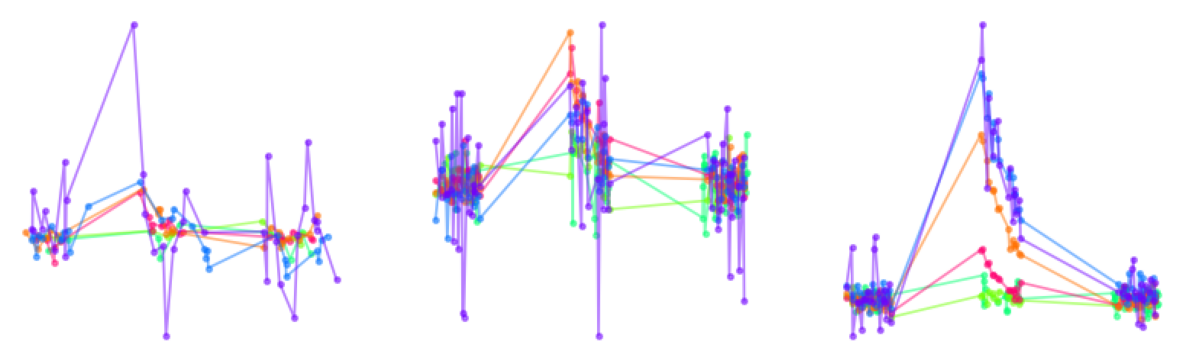

In [9]:
num_images = len(train_data['pixel_values'])
random_indices = random.sample(range(num_images), 3)
images = [train_data['pixel_values'][i] for i in random_indices]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, ax in enumerate(axs):
    ax.imshow(images[i])
    ax.axis('off') 

plt.show()

### Dataloader

In [10]:
# I know previously what my class mapping is. I could use this to plot the confusion matrix
dict_mapping_classes = {
  'RR lyrae': 0,
  'AGN': 1,
  'SNII': 2,
  'SNIa': 3,
  'M-dwarf': 4,
  'Eclip. Binary': 5,
  'SNIa-91bg': 6,
  'SLSN-I': 7,
  'SNIbc': 8,
  'TDE': 9,
  'SNIax': 10,
  'Single u-lens': 11,
  'Kilonova': 12,
  'Mira': 13,
  }

inv_dict_mapping_classes = {value: key for key, value in dict_mapping_classes.items()}

In [11]:
num_classes = len(np.unique(train_data['y_true']))
num_classes

14

In [12]:
batch_size = 64

class CustomDataset(Dataset):
    def __init__(self, data):
        self.ids = data['id']
        self.pixel_values = torch.from_numpy(data['pixel_values']).float()
        self.y_true = torch.from_numpy(data['y_true']).long()

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        return {
            'id': self.ids[idx],
            'pixel_values': self.pixel_values[idx],
            'y_true': self.y_true[idx]
        }

train_dataset = CustomDataset(train_data)
val_dataset = CustomDataset(val_data)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

## Finetuning

### Model

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

pt_model_name = 'google/vit-base-patch32-224-in21k'
processor = ViTImageProcessor.from_pretrained(pt_model_name)
model = ViTModel.from_pretrained(pt_model_name).to(device)

classifier = nn.Linear(model.config.hidden_size, num_classes).to(device)

### Training

In [14]:
def train_step(batch_data, model, processor, classifier, optimizer, device):
    model.train()
    y_true = batch_data['y_true'].to(device)

    inputs = processor(images=batch_data['pixel_values'], return_tensors="pt").to(device)
    outputs = model(**inputs)
    pooled_output = outputs.last_hidden_state[:, 0, :]

    logits = classifier(pooled_output)
    loss = F.cross_entropy(logits, y_true)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    y_pred = torch.argmax(logits, dim=-1)
    return loss.item(), y_pred, y_true
    

def validate_step(batch_data, model, processor, classifier, device):
    model.eval()
    with torch.no_grad():
        y_true = batch_data['y_true'].to(device)

        inputs = processor(images=batch_data['pixel_values'], return_tensors="pt").to(device)
        outputs = model(**inputs)
        pooled_output = outputs.last_hidden_state[:, 0, :]

        logits = classifier(pooled_output)
        loss = F.cross_entropy(logits, y_true)

        y_pred = torch.argmax(logits, dim=-1)
        return loss.item(), y_pred, y_true


def predict_step(batch_data, model, processor, classifier, device):
    model.eval()
    with torch.no_grad():
        y_true = batch_data['y_true'].to(device)

        inputs = processor(images=batch_data['pixel_values'], return_tensors="pt").to(device)
        outputs = model(**inputs)
        pooled_output = outputs.last_hidden_state[:, 0, :]

        logits = classifier(pooled_output)
        y_pred_prob = F.softmax(logits, dim=1)
        y_pred = torch.argmax(logits, dim=-1)

        return {
            'id': batch_data['id'],
            'y_pred': y_pred.cpu().numpy(),
            'y_pred_prob': y_pred_prob.cpu().numpy(),
            'y_true': y_true.cpu().numpy()
        }

In [15]:
lr = 2e-5 # 5.0e-6
num_epochs = 1000
patience = 7 
best_val_f1 = 0.0
patience_counter = 0
best_model_path = 'best_model_vit.pth'  # Ruta donde se guardará el mejor modelo

params = list(model.parameters()) + list(classifier.parameters())
optimizer = optim.Adam(params, lr=lr)

# Inicializar métricas F1
f1_train = F1Score(task="multiclass", num_classes=num_classes, average='macro').to(device)
f1_val = F1Score(task="multiclass", num_classes=num_classes, average='macro').to(device)

# Bucle de entrenamiento y validación
for epoch in range(num_epochs):
    # Resetear métricas para cada epoch
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    f1_train.reset()

    model.train()
    for batch_idx, batch_data in enumerate(train_dataloader):
        loss, y_pred, y_true = train_step(batch_data, model, processor, classifier, optimizer, device)
        
        train_loss += loss
        train_correct += (y_pred == y_true).sum()
        train_total += y_true.size(0)

        # Actualizar F1 Score para el conjunto de entrenamiento
        f1_train.update(y_pred, y_true)

    train_loss /= len(train_dataloader)
    train_accuracy = 100. * train_correct / train_total
    train_f1_score = f1_train.compute()

    # Validación
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    f1_val.reset()

    model.eval()
    with torch.no_grad():
        for batch_idx, batch_data in enumerate(val_dataloader):
            loss, y_pred, y_true = validate_step(batch_data, model, processor, classifier, device)
            
            val_loss += loss
            val_correct += (y_pred == y_true).sum()
            val_total += y_true.size(0)

            # Actualizar F1 Score para el conjunto de validación
            f1_val.update(y_pred, y_true)

    val_loss /= len(val_dataloader)
    val_accuracy = 100. * val_correct / val_total
    val_f1_score = f1_val.compute()

    # Imprimir resultados de la época
    print(f'Epoch {epoch+1}/{num_epochs} | '
          f'Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.2f}% | Train F1: {train_f1_score:.4f} | '
          f'Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.2f}% | Val F1: {val_f1_score:.4f}')

    # Early stopping basado en el F1 Score de validación y guardado del mejor modelo
    if val_f1_score > best_val_f1:
        best_val_f1 = val_f1_score
        patience_counter = 0  # Restablecer el contador de paciencia
        torch.save(model.state_dict(), best_model_path)  # Guardar el mejor modelo
        print(f"New best model saved at epoch {epoch+1}")
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break

print(f"Training complete. Best model saved with F1 Score: {best_val_f1:.4f}")

Epoch 1/1000 | Train Loss: 1.9763 | Train Acc: 41.62% | Train F1: 0.1392 | Val Loss: 1.5778 | Val Acc: 56.05% | Val F1: 0.2389
New best model saved at epoch 1
Epoch 2/1000 | Train Loss: 1.4012 | Train Acc: 63.33% | Train F1: 0.3440 | Val Loss: 1.2413 | Val Acc: 69.94% | Val F1: 0.4003
New best model saved at epoch 2
Epoch 3/1000 | Train Loss: 1.1325 | Train Acc: 71.07% | Train F1: 0.4208 | Val Loss: 1.1032 | Val Acc: 71.21% | Val F1: 0.4291
New best model saved at epoch 3
Epoch 4/1000 | Train Loss: 0.9747 | Train Acc: 75.01% | Train F1: 0.4644 | Val Loss: 1.0196 | Val Acc: 74.08% | Val F1: 0.4730
New best model saved at epoch 4
Epoch 5/1000 | Train Loss: 0.8268 | Train Acc: 79.42% | Train F1: 0.5186 | Val Loss: 0.9772 | Val Acc: 71.72% | Val F1: 0.4649
Epoch 6/1000 | Train Loss: 0.6944 | Train Acc: 83.77% | Train F1: 0.6025 | Val Loss: 0.9481 | Val Acc: 72.99% | Val F1: 0.4890
New best model saved at epoch 6
Epoch 7/1000 | Train Loss: 0.5728 | Train Acc: 87.66% | Train F1: 0.6857 | Val

## Inference

Here, you should use the test data; however, I will use the validation data.

In [16]:
# Cargar el mejor modelo guardado
model.load_state_dict(torch.load(best_model_path, weights_only=True))
model.eval()

outputs = []
with torch.no_grad():
    for batch_data in val_dataloader: 
        outputs.append(predict_step(batch_data, model, processor, classifier, device))

In [17]:
outputs[0].keys()

dict_keys(['id', 'y_pred', 'y_pred_prob', 'y_true'])

In [18]:
keys = outputs[0].keys()
outputs_dict = {key: [] for key in keys}

for i in range(len(outputs)):
    for key in keys:
        outputs_dict[key].append(outputs[i][key])

outputs_dict = {key: np.concatenate(values) for key, values in outputs_dict.items()}
outputs_dict

{'id': array(['615', '730', '745', ..., '130659834', '130727624', '130772921'],
       dtype='<U9'),
 'y_pred': array([0, 2, 3, ..., 2, 4, 4]),
 'y_pred_prob': array([[9.6365011e-01, 3.2468382e-03, 2.7458041e-03, ..., 3.0617961e-03,
         2.7836883e-03, 3.5194103e-03],
        [1.3174276e-03, 1.0628911e-03, 9.7779226e-01, ..., 8.5619488e-04,
         1.1975209e-03, 1.0620076e-03],
        [6.6109677e-04, 1.0694575e-03, 1.2065519e-03, ..., 7.8246027e-04,
         6.2201323e-04, 8.2739332e-04],
        ...,
        [9.6820872e-03, 5.9061525e-03, 5.2811754e-01, ..., 5.6442930e-03,
         6.9179372e-03, 8.1221601e-03],
        [1.5040699e-03, 1.3233146e-03, 1.7414055e-03, ..., 1.4875709e-03,
         1.9415037e-03, 1.4905751e-03],
        [1.3562248e-03, 1.4078043e-03, 1.4974347e-03, ..., 1.3867635e-03,
         2.1076321e-03, 1.4706883e-03]], dtype=float32),
 'y_true': array([0, 2, 3, ..., 2, 4, 4])}

In [19]:
outputs_dict['y_true'] = [inv_dict_mapping_classes[val] for val in outputs_dict['y_true']]
outputs_dict['y_pred'] = [inv_dict_mapping_classes[val] for val in outputs_dict['y_pred']]

In [20]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(outputs_dict['y_true'], outputs_dict['y_pred'], digits=4))

               precision    recall  f1-score   support

          AGN     0.9221    0.9595    0.9404        74
Eclip. Binary     0.9526    0.9837    0.9679       184
     Kilonova     0.2222    0.3000    0.2553        20
      M-dwarf     0.8273    0.9239    0.8729       197
         Mira     1.0000    1.0000    1.0000         6
     RR lyrae     1.0000    0.9375    0.9677        48
       SLSN-I     0.4848    0.4571    0.4706        35
         SNII     0.5000    0.6067    0.5482       239
         SNIa     0.8388    0.5519    0.6658       462
    SNIa-91bg     0.2170    0.5476    0.3108        42
        SNIax     0.1569    0.2222    0.1839        36
        SNIbc     0.4021    0.4021    0.4021        97
Single u-lens     0.7778    0.4516    0.5714        31
          TDE     0.6981    0.7475    0.7220        99

     accuracy                         0.6783      1570
    macro avg     0.6428    0.6494    0.6342      1570
 weighted avg     0.7235    0.6783    0.6880      1570



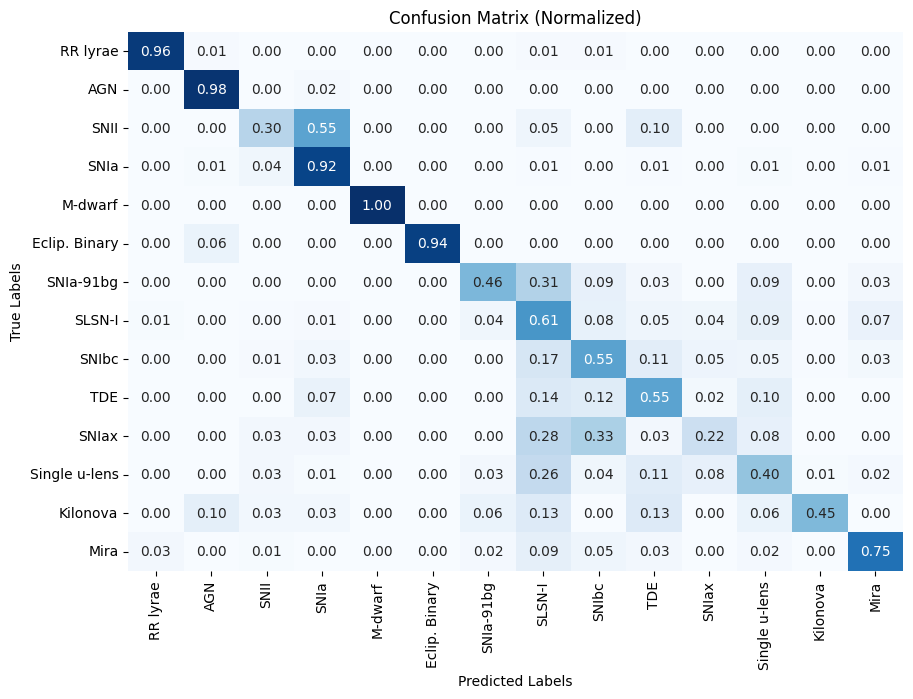

In [22]:
# Crear la matriz de confusión
cm = confusion_matrix(outputs_dict['y_true'], outputs_dict['y_pred'])

# Normalizar la matriz de confusión por filas (verdaderos)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Obtener los nombres de las clases desde el diccionario
class_names = inv_dict_mapping_classes.values()

# Dibujar el heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Normalized)')
plt.show()